In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

In [4]:
import torch

# Données synthétiques

In [5]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [6]:
import itertools
mu = 1.0
tmax = 20.0
alpha = 0.2
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 25.000


In [82]:
n_traj = 10
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

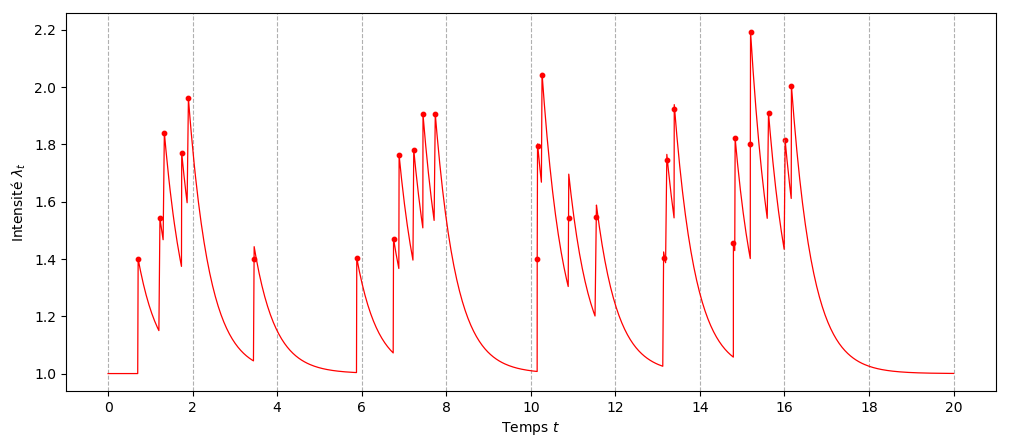

In [83]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [84]:
input_size = max(s.shape[0] for s in sample_trajectories)
print("Input size max. traj. length: \t%d" % input_size)
print("Number of samples: \t\t%d" % len(sample_trajectories))
length_array = [s.shape[0] for s in sample_trajectories]
data_array = np.stack([np.pad(s[:,0], ((0, input_size - s.shape[0])), 'constant') for s in sample_trajectories])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

Input size max. traj. length: 	31
Number of samples: 		10


In [85]:
data_tensor.shape

torch.Size([10, 31])

In [86]:
length_array

[27, 31, 17, 21, 21, 26, 20, 23, 23, 27]

The first dimension is for time, the second for the sample.

## Neural net

In [11]:
import torch
import torch.nn as nn
from torch import optim

In [12]:
device = torch.device("cpu")
print(device)

cpu


In [87]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [159]:
from model import NeuralCTLSTM

In [160]:
nhlstm = NeuralCTLSTM(10)
optimizer = optim.SGD(nhlstm.parameters(), lr=0.0001)

# We use mini-batches to train on our data
BATCH_SIZE = 5
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

Batch size: 5
Training sample size: 10
Splitting into batches of 5
No. of batches: 2


In [161]:
inter_t.shape

torch.Size([5, 30])

In [162]:

nhlstm.zero_grad()
for i in range(num_of_batches):
    # Train on each batch
    event_times = split_into_batches[i]
    inter_t = event_times[:,:-1] - event_times[:,1:] # transform into inter-arrival times
    batch_size = inter_t.size(0)
    print("Running batch %d, size %d." % (i, batch_size), end=' ')
    output_hist = []
    hidden_hist = []
    cell_hist = []
    cell_target_hist = []
    decay_hist = []
    nhlstm.init_hidden(batch_size)
    for i in range(batch_size):
        # Loop over time
        # Feed the RNN each batch of times
        output, hidden, ct, cbar, decay_t = nhlstm(inter_t[:,i])
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(ct)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
        print('output shape %s ' % str(output.shape))
    output_hist = torch.stack(output_hist)
    hidden_hist = torch.stack(hidden_hist)
    cell_hist = torch.stack(cell_hist)
    cell_target_hist = torch.stack(cell_target_hist)
    decay_hist = torch.stack(decay_hist)

    loss = nhlstm.likelihood(event_times, cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
    print("Loss: %.5f" % loss.item())
    loss.backward()  # compute the gradients
    optimizer.step() # do a step of the SGD algorithm


Running batch 0, size 5. > /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(108)forward()
-> c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)


(Pdb)  s


--Call--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(55)c_func()
-> def c_func(self, dt: torch.Tensor, c: torch.Tensor,


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(65)c_func()
-> dt_expd = dt.unsqueeze(1).expand(c.shape)


(Pdb)  s


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(66)c_func()
-> return cbar + (c - cbar) * torch.exp(-decay * dt_expd)


(Pdb)  dt_expd*decay


tensor([[-0.3751, -0.4369, -0.3702, -0.3716, -0.4080, -0.3358, -0.4018, -0.3364,
         -0.3203, -0.3079],
        [-0.3025, -0.4085, -0.2590, -0.4057, -0.2813, -0.2674, -0.3195, -0.3224,
         -0.2839, -0.3847],
        [-0.0942, -0.1255, -0.0882, -0.0854, -0.0951, -0.0896, -0.0770, -0.1056,
         -0.0914, -0.0857],
        [-0.9864, -1.8570, -1.1054, -1.1232, -0.9369, -0.7264, -0.9417, -0.8128,
         -0.9454, -0.9460],
        [-0.0799, -0.1205, -0.0708, -0.0702, -0.0845, -0.0765, -0.0787, -0.0690,
         -0.0811, -0.0739]], grad_fn=<ThMulBackward>)


(Pdb)  s


--Return--
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(66)c_func()->tensor([[ 1.0...hAddBackward>)
-> return cbar + (c - cbar) * torch.exp(-decay * dt_expd)


(Pdb)  n


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(110)forward()
-> c_ti = forget * c_t_after + input * zi


(Pdb)  n


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(112)forward()
-> cbar = forget_target * cbar + input_target * zi


(Pdb)  n


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(113)forward()
-> h_ti = output * torch.tanh(c_t_after)


(Pdb)  n


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(116)forward()
-> self.hidden = h_ti, c_ti, cbar


(Pdb)  n


> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(117)forward()
-> return output, h_ti, c_ti, cbar, decay_t


(Pdb)  continue


output shape torch.Size([5, 10]) 
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(108)forward()
-> c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)


(Pdb)  continue


output shape torch.Size([5, 10]) 
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(108)forward()
-> c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)


(Pdb)  continue


output shape torch.Size([5, 10]) 
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(108)forward()
-> c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)
--KeyboardInterrupt--


(Pdb)  continue


output shape torch.Size([5, 10]) 
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(108)forward()
-> c_t_after = self.c_func(inter_times, c_ti, cbar, decay_t)
--KeyboardInterrupt--
--KeyboardInterrupt--


(Pdb)  
(Pdb)  c


output shape torch.Size([5, 10]) 
Computing loss for LSTM...
> /home/manifold/Documents/etudes/map511-p3a/notebooks/model.py(156)likelihood()
-> inter_times = event_times[:, -1:] - event_times[:, 1:]


(Pdb)  c


RuntimeError: The expanded size of the tensor (10) must match the existing size (30) at non-singleton dimension 2

In [148]:
dt = torch.rand(5)
decay = torch.rand(5,10)

In [151]:
dt_expd = dt.unsqueeze(1).expand(5,10)

In [152]:
dt_expd.shape

torch.Size([5, 10])

In [153]:
res = dt_expd*decay

In [154]:
res.shape

torch.Size([5, 10])